# Shared Timescale Sweep Analysis

**Research Question**: When all neurons share a single learnable timescale, what value does the network converge to? Does it match the behavioral timescale?

This notebook analyzes the shared timescale sweep experiment where:
- All neurons share a SINGLE learnable timescale (scalar parameter)
- Each experiment starts with a different initial timescale
- We compare Tanh vs ReLU activation functions


## Setup


In [1]:
%load_ext autoreload
%autoreload 2

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
sys.path.append(os.getcwd())


Working directory:  /home/facosta/timescales/timescales


In [2]:
from pathlib import Path
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

In [3]:
# Sweep directory
sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/shared_timescale_sweep_20260120_170223"
)
print(f"Sweep directory: {sweep_dir}")
print(f"Exists: {sweep_dir.exists()}")

# List experiments
exp_dirs = [d for d in sweep_dir.iterdir() if d.is_dir() and d.name.startswith("shared_tau_")]
print(f"\nFound {len(exp_dirs)} experiments:")
for d in sorted(exp_dirs):
    print(f"  - {d.name}")

Sweep directory: /home/facosta/timescales/timescales/logs/experiments/shared_timescale_sweep_20260120_170223
Exists: True

Found 16 experiments:
  - shared_tau_0.05_ReLU
  - shared_tau_0.05_Tanh
  - shared_tau_0.1_ReLU
  - shared_tau_0.1_Tanh
  - shared_tau_0.2_ReLU
  - shared_tau_0.2_Tanh
  - shared_tau_0.3_ReLU
  - shared_tau_0.3_Tanh
  - shared_tau_0.5_ReLU
  - shared_tau_0.5_Tanh
  - shared_tau_0.7_ReLU
  - shared_tau_0.7_Tanh
  - shared_tau_1.5_ReLU
  - shared_tau_1.5_Tanh
  - shared_tau_1_ReLU
  - shared_tau_1_Tanh


## Load Data


In [4]:
def load_experiment_data(exp_path: Path, seed: int = 0):
    """Load all relevant data from an experiment."""
    seed_path = exp_path / f"seed_{seed}"
    
    # Load config
    config_path = seed_path / f"config_seed{seed}.yaml"
    with open(config_path) as f:
        config = yaml.safe_load(f)
    
    # Load training losses
    with open(seed_path / "training_losses.json") as f:
        losses = json.load(f)
    
    # Load position decoding errors
    with open(seed_path / "position_decoding_errors.json") as f:
        decoding = json.load(f)
    
    # Load timescale history
    with open(seed_path / "timescale_history.json") as f:
        timescales = json.load(f)
    
    return {
        "config": config,
        "losses": losses,
        "decoding": decoding,
        "timescales": timescales,
        "init_timescale": config["init_timescale"],
        "activation": config["activation"],
        "behavioral_timescale_mean": config.get("behavioral_timescale_mean", 0.7),
        "behavioral_timescale_std": config.get("behavioral_timescale_std", 0.05),
    }


# Load all experiments
experiments = {}
for exp_dir in sorted(exp_dirs):
    try:
        data = load_experiment_data(exp_dir)
        key = (data["init_timescale"], data["activation"])
        experiments[key] = data
        print(f"Loaded {exp_dir.name}: init_tau={data['init_timescale']}, activation={data['activation']}")
    except Exception as e:
        print(f"Failed to load {exp_dir.name}: {e}")

print(f"\nLoaded {len(experiments)} experiments")

Loaded shared_tau_0.05_ReLU: init_tau=0.05, activation=ReLU
Loaded shared_tau_0.05_Tanh: init_tau=0.05, activation=Tanh
Loaded shared_tau_0.1_ReLU: init_tau=0.1, activation=ReLU
Loaded shared_tau_0.1_Tanh: init_tau=0.1, activation=Tanh
Loaded shared_tau_0.2_ReLU: init_tau=0.2, activation=ReLU
Loaded shared_tau_0.2_Tanh: init_tau=0.2, activation=Tanh
Loaded shared_tau_0.3_ReLU: init_tau=0.3, activation=ReLU
Loaded shared_tau_0.3_Tanh: init_tau=0.3, activation=Tanh
Loaded shared_tau_0.5_ReLU: init_tau=0.5, activation=ReLU
Loaded shared_tau_0.5_Tanh: init_tau=0.5, activation=Tanh
Loaded shared_tau_0.7_ReLU: init_tau=0.7, activation=ReLU
Loaded shared_tau_0.7_Tanh: init_tau=0.7, activation=Tanh
Loaded shared_tau_1.5_ReLU: init_tau=1.5, activation=ReLU
Loaded shared_tau_1.5_Tanh: init_tau=1.5, activation=Tanh
Loaded shared_tau_1_ReLU: init_tau=1.0, activation=ReLU
Loaded shared_tau_1_Tanh: init_tau=1.0, activation=Tanh

Loaded 16 experiments


In [5]:
# Get unique values
init_timescales = sorted(set(k[0] for k in experiments.keys()))
activations = sorted(set(k[1] for k in experiments.keys()))
print(f"Initial timescales: {init_timescales}")
print(f"Activations: {activations}")

# Get behavioral timescale (should be same for all)
first_exp = list(experiments.values())[0]
behavioral_tau_mean = first_exp["behavioral_timescale_mean"]
behavioral_tau_std = first_exp["behavioral_timescale_std"]
print(f"\nBehavioral timescale: {behavioral_tau_mean} ± {behavioral_tau_std}")

Initial timescales: [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5]
Activations: ['ReLU', 'Tanh']

Behavioral timescale: 0.7 ± 0.05


## 1. Train Loss vs Epochs (Log-Log Scale)

Curves colored by initial timescale, with different colormaps for Tanh (blues) vs ReLU (oranges).


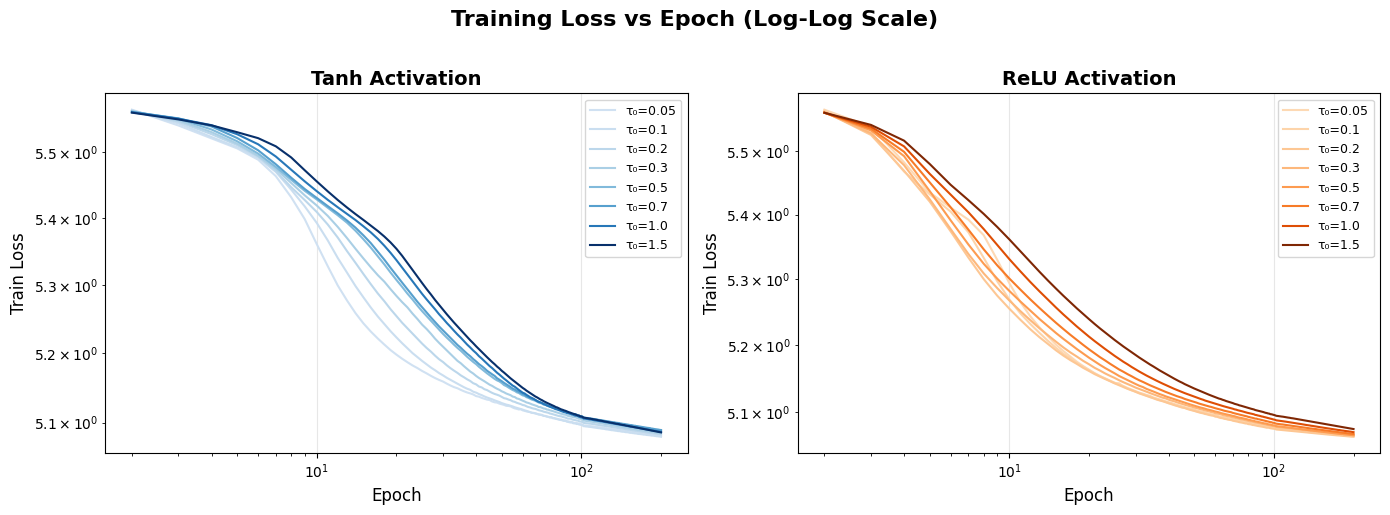

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Colormaps for each activation
cmap_tanh = cm.Blues
cmap_relu = cm.Oranges

# Normalize by init_timescale range
norm = Normalize(vmin=min(init_timescales), vmax=max(init_timescales))

for ax, activation in zip(axes, ["Tanh", "ReLU"]):
    cmap = cmap_tanh if activation == "Tanh" else cmap_relu
    
    for init_tau in init_timescales:
        key = (init_tau, activation)
        if key not in experiments:
            continue
        
        data = experiments[key]
        epochs = np.array(data["losses"]["epochs"]) + 1  # 1-indexed for log scale
        train_loss = np.array(data["losses"]["train_losses_epoch"])
        
        color = cmap(norm(init_tau) * 0.8 + 0.2)  # Shift to avoid very light colors
        ax.loglog(epochs[1:], train_loss, color=color, linewidth=1.5, 
                  label=f"τ₀={init_tau}")
    
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Train Loss", fontsize=12)
    ax.set_title(f"{activation} Activation", fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Training Loss vs Epoch (Log-Log Scale)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 2. Position Decoding Error vs Epochs (Log-Log Scale)


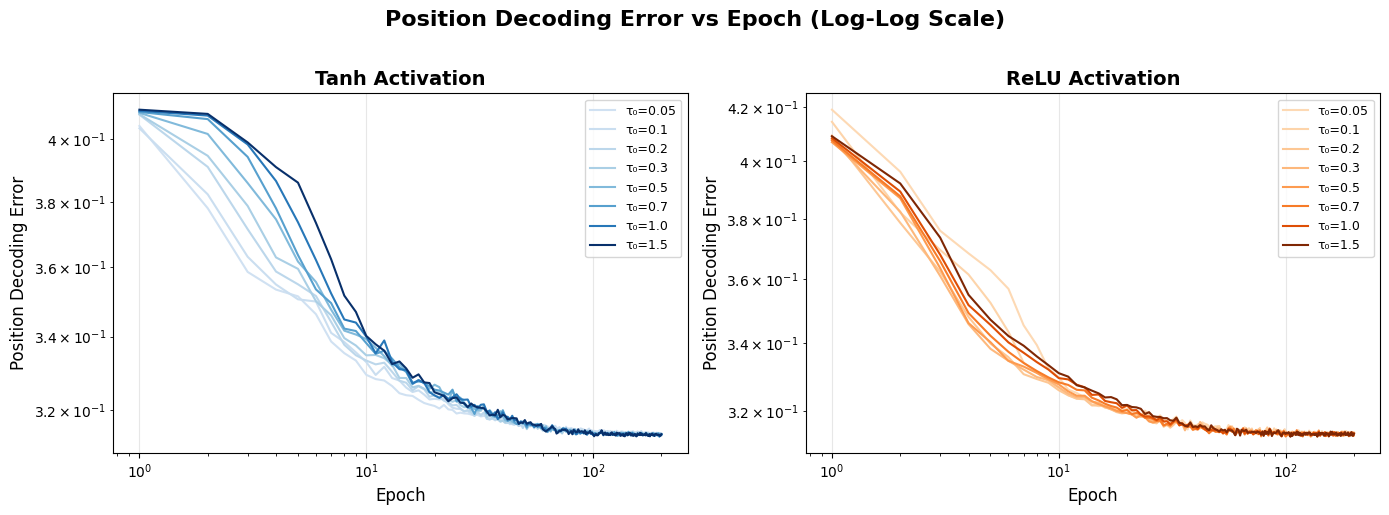

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

norm = Normalize(vmin=min(init_timescales), vmax=max(init_timescales))

for ax, activation in zip(axes, ["Tanh", "ReLU"]):
    cmap = cmap_tanh if activation == "Tanh" else cmap_relu
    
    for init_tau in init_timescales:
        key = (init_tau, activation)
        if key not in experiments:
            continue
        
        data = experiments[key]
        epochs = np.array(data["decoding"]["epochs"]) + 1
        decoding_error = np.array(data["decoding"]["position_errors_epoch"])
        
        color = cmap(norm(init_tau) * 0.8 + 0.2)
        ax.loglog(epochs, decoding_error, color=color, linewidth=1.5, 
                  label=f"τ₀={init_tau}")
    
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Position Decoding Error", fontsize=12)
    ax.set_title(f"{activation} Activation", fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Position Decoding Error vs Epoch (Log-Log Scale)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 3. Initial vs Final vs Behavioral Timescale

For each model, show the initial timescale, final learned timescale, and reference behavioral timescale.


In [9]:
# Extract initial and final timescales for each experiment
summary_data = []

for key, data in experiments.items():
    init_tau, activation = key
    
    # Get initial and final timescale from history
    timescale_mean = data["timescales"]["mean"]
    initial_tau = timescale_mean[0]
    final_tau = timescale_mean[-1]
    
    summary_data.append({
        "init_tau": init_tau,
        "activation": activation,
        "initial_learned_tau": initial_tau,
        "final_learned_tau": final_tau,
    })

# Sort by init_tau and activation
summary_data = sorted(summary_data, key=lambda x: (x["activation"], x["init_tau"]))

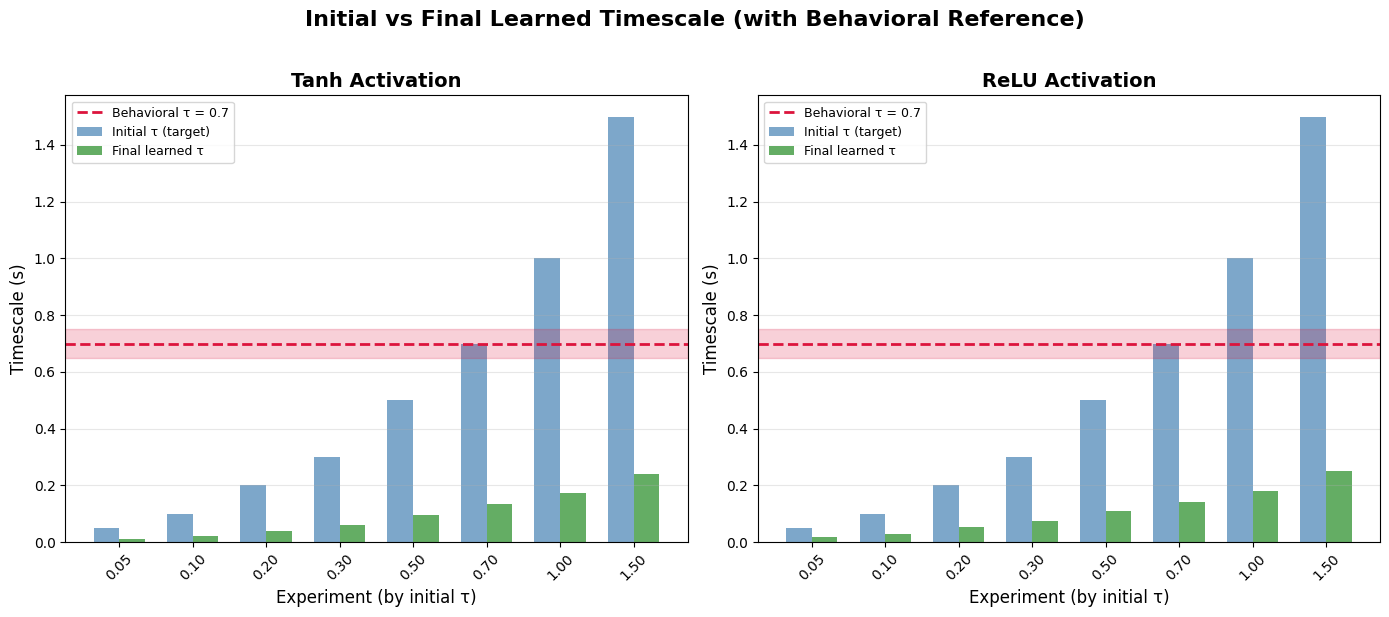

In [10]:
# Bar plot: Initial vs Final timescale for each model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, activation in zip(axes, ["Tanh", "ReLU"]):
    act_data = [d for d in summary_data if d["activation"] == activation]
    
    x_vals = np.arange(len(act_data))
    init_taus = [d["init_tau"] for d in act_data]
    initial_learned = [d["initial_learned_tau"] for d in act_data]
    final_learned = [d["final_learned_tau"] for d in act_data]
    
    bar_width = 0.35
    
    # Plot initial (target) timescale
    bars1 = ax.bar(x_vals - bar_width/2, init_taus, bar_width, 
                   label="Initial τ (target)", color="steelblue", alpha=0.7)
    
    # Plot final learned timescale
    bars2 = ax.bar(x_vals + bar_width/2, final_learned, bar_width,
                   label="Final learned τ", color="forestgreen", alpha=0.7)
    
    # Plot behavioral timescale reference
    ax.axhline(y=behavioral_tau_mean, color="crimson", linestyle="--", linewidth=2,
               label=f"Behavioral τ = {behavioral_tau_mean}")
    ax.axhspan(behavioral_tau_mean - behavioral_tau_std, 
               behavioral_tau_mean + behavioral_tau_std,
               alpha=0.2, color="crimson")
    
    ax.set_xlabel("Experiment (by initial τ)", fontsize=12)
    ax.set_ylabel("Timescale (s)", fontsize=12)
    ax.set_title(f"{activation} Activation", fontsize=14, fontweight="bold")
    ax.set_xticks(x_vals)
    ax.set_xticklabels([f"{t:.2f}" for t in init_taus], rotation=45)
    ax.legend(loc="upper left", fontsize=9)
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle("Initial vs Final Learned Timescale (with Behavioral Reference)", 
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

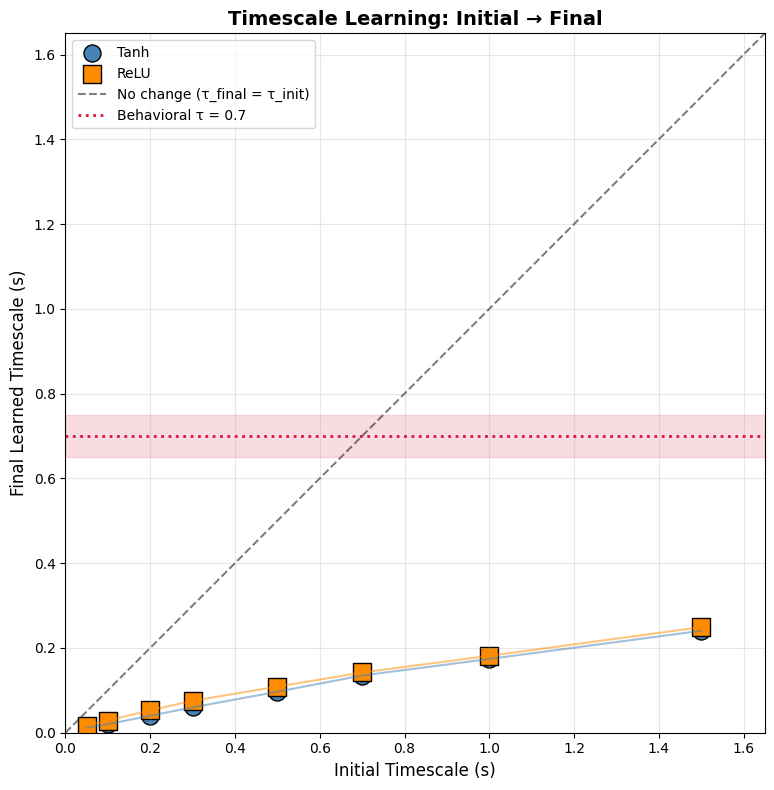

In [11]:
# Scatter plot: Initial vs Final timescale
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = {"Tanh": "steelblue", "ReLU": "darkorange"}
markers = {"Tanh": "o", "ReLU": "s"}

for activation in ["Tanh", "ReLU"]:
    act_data = [d for d in summary_data if d["activation"] == activation]
    init_taus = [d["init_tau"] for d in act_data]
    final_taus = [d["final_learned_tau"] for d in act_data]
    
    ax.scatter(init_taus, final_taus, s=150, c=colors[activation], 
               marker=markers[activation], label=activation, edgecolors="black", linewidth=1)
    
    # Connect points with lines
    ax.plot(init_taus, final_taus, c=colors[activation], alpha=0.5, linewidth=1.5)

# Diagonal line (no change)
max_val = max(init_timescales) * 1.1
ax.plot([0, max_val], [0, max_val], "k--", alpha=0.5, label="No change (τ_final = τ_init)")

# Behavioral timescale reference
ax.axhline(y=behavioral_tau_mean, color="crimson", linestyle=":", linewidth=2,
           label=f"Behavioral τ = {behavioral_tau_mean}")
ax.axhspan(behavioral_tau_mean - behavioral_tau_std, 
           behavioral_tau_mean + behavioral_tau_std,
           alpha=0.15, color="crimson")

ax.set_xlabel("Initial Timescale (s)", fontsize=12)
ax.set_ylabel("Final Learned Timescale (s)", fontsize=12)
ax.set_title("Timescale Learning: Initial → Final", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

## 4. Timescale Evolution Over Training


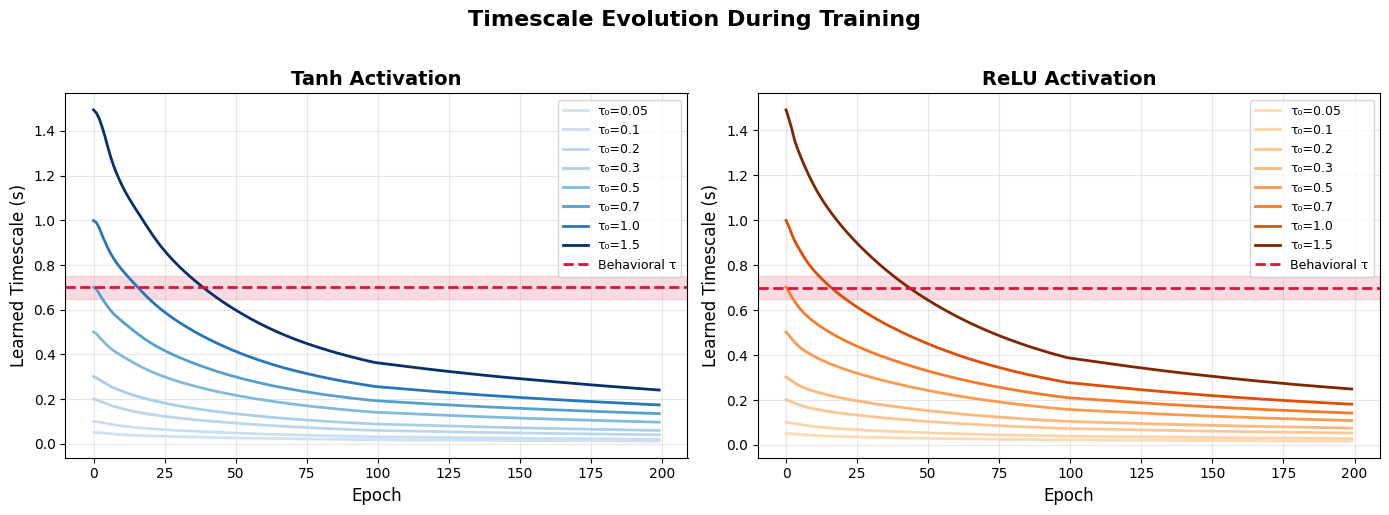

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

norm = Normalize(vmin=min(init_timescales), vmax=max(init_timescales))

for ax, activation in zip(axes, ["Tanh", "ReLU"]):
    cmap = cmap_tanh if activation == "Tanh" else cmap_relu
    
    for init_tau in init_timescales:
        key = (init_tau, activation)
        if key not in experiments:
            continue
        
        data = experiments[key]
        epochs = np.array(data["timescales"]["epochs"])
        tau_mean = np.array(data["timescales"]["mean"])
        
        color = cmap(norm(init_tau) * 0.8 + 0.2)
        ax.plot(epochs, tau_mean, color=color, linewidth=2, label=f"τ₀={init_tau}")
    
    # Behavioral timescale reference
    ax.axhline(y=behavioral_tau_mean, color="crimson", linestyle="--", linewidth=2,
               label=f"Behavioral τ")
    ax.axhspan(behavioral_tau_mean - behavioral_tau_std, 
               behavioral_tau_mean + behavioral_tau_std,
               alpha=0.15, color="crimson")
    
    ax.set_xlabel("Epoch", fontsize=12)
    ax.set_ylabel("Learned Timescale (s)", fontsize=12)
    ax.set_title(f"{activation} Activation", fontsize=14, fontweight="bold")
    ax.legend(loc="best", fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Timescale Evolution During Training", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 5. Summary Statistics


In [13]:
print("=" * 80)
print("Summary: Initial vs Final Timescales")
print("=" * 80)
print(f"\nBehavioral timescale: {behavioral_tau_mean:.3f} ± {behavioral_tau_std:.3f}")
print("\n" + "-" * 80)

for activation in ["Tanh", "ReLU"]:
    print(f"\n{activation} Activation:")
    print(f"{'Init τ':>10} | {'Final τ':>10} | {'Change':>10} | {'Rel. Change':>12}")
    print("-" * 50)
    
    act_data = [d for d in summary_data if d["activation"] == activation]
    for d in act_data:
        init = d["init_tau"]
        final = d["final_learned_tau"]
        change = final - init
        rel_change = (change / init) * 100
        print(f"{init:>10.3f} | {final:>10.4f} | {change:>+10.4f} | {rel_change:>+11.1f}%")

Summary: Initial vs Final Timescales

Behavioral timescale: 0.700 ± 0.050

--------------------------------------------------------------------------------

Tanh Activation:
    Init τ |    Final τ |     Change |  Rel. Change
--------------------------------------------------
     0.050 |     0.0119 |    -0.0381 |       -76.3%
     0.100 |     0.0202 |    -0.0798 |       -79.8%
     0.200 |     0.0402 |    -0.1598 |       -79.9%
     0.300 |     0.0597 |    -0.2403 |       -80.1%
     0.500 |     0.0968 |    -0.4032 |       -80.6%
     0.700 |     0.1350 |    -0.5650 |       -80.7%
     1.000 |     0.1739 |    -0.8261 |       -82.6%
     1.500 |     0.2406 |    -1.2594 |       -84.0%

ReLU Activation:
    Init τ |    Final τ |     Change |  Rel. Change
--------------------------------------------------
     0.050 |     0.0170 |    -0.0330 |       -66.1%
     0.100 |     0.0285 |    -0.0715 |       -71.5%
     0.200 |     0.0530 |    -0.1470 |       -73.5%
     0.300 |     0.0752 |    -

In [14]:
# Key finding: Do all initializations converge to similar values?
print("\n" + "=" * 80)
print("Key Finding: Convergence Analysis")
print("=" * 80)

for activation in ["Tanh", "ReLU"]:
    act_data = [d for d in summary_data if d["activation"] == activation]
    final_taus = [d["final_learned_tau"] for d in act_data]
    
    print(f"\n{activation}:")
    print(f"  Final τ range: {min(final_taus):.4f} - {max(final_taus):.4f}")
    print(f"  Final τ mean:  {np.mean(final_taus):.4f}")
    print(f"  Final τ std:   {np.std(final_taus):.4f}")
    print(f"  Behavioral τ:  {behavioral_tau_mean:.4f}")
    print(f"  Converged to behavioral? {abs(np.mean(final_taus) - behavioral_tau_mean) < behavioral_tau_std}")


Key Finding: Convergence Analysis

Tanh:
  Final τ range: 0.0119 - 0.2406
  Final τ mean:  0.0973
  Final τ std:   0.0756
  Behavioral τ:  0.7000
  Converged to behavioral? False

ReLU:
  Final τ range: 0.0170 - 0.2491
  Final τ mean:  0.1069
  Final τ std:   0.0751
  Behavioral τ:  0.7000
  Converged to behavioral? False
